# NeRF Training

In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from dataset import get_rays
from model import Nerf
from ml_helpers import training

In [ ]:
batch_size = 1024 # how many rays to use per batch. More rays means more GPU needed
height = 400 # image height
width = 400 # image width
imgs = 100 # ammount of images used for training in the dataset being used
dataset_path = 'datasets/monkey_3'

## Calculate rays from pose data
Find ray origins and directions for training and test data. This is done using the focal length for each camera pose, and the rotation and position of each camera pose data.

In [2]:
o, d, target_px_values = get_rays(dataset_path, mode='train')

dataloader = DataLoader(torch.cat((torch.from_numpy(o).reshape(-1, 3).type(torch.float),
                                   torch.from_numpy(d).reshape(-1, 3).type(torch.float),
                                   torch.from_numpy(target_px_values).reshape(-1, 3).type(torch.float)), dim=1),
                       batch_size=batch_size, shuffle=True)


dataloader_warmup = DataLoader(torch.cat((torch.from_numpy(o).reshape(imgs, height, width, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(d).reshape(imgs, height, width, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(target_px_values).reshape(imgs, height, width, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float)), dim=1),
                       batch_size=batch_size, shuffle=True)


test_o, test_d, test_target_px_values = get_rays(dataset_path, mode='test')

## Model Training
Change model name for your custom model

In [3]:
pth_file = 'nerf_models/monkey_biz.pth'

100%|██████████| 3907/3907 [01:42<00:00, 37.95it/s]


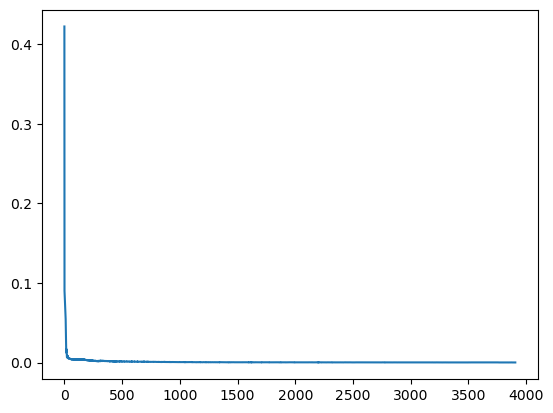

100%|██████████| 15625/15625 [06:50<00:00, 38.07it/s]


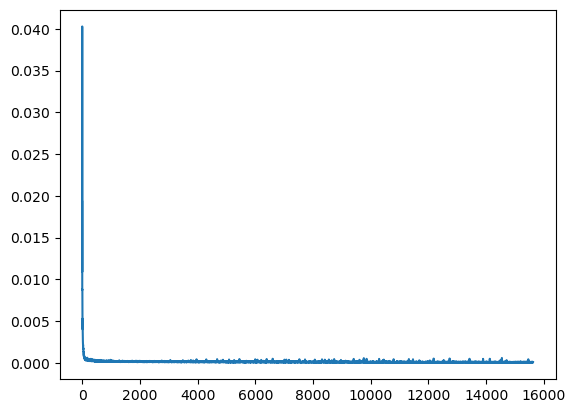

In [4]:
device = 'cuda'

tn = 8.
tf = 12.
nb_epochs = 1
lr = 1e-3
gamma = .5
nb_bins = 100

model = Nerf(hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)

training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, model_name=pth_file, device=device)
plt.plot(training_loss)
plt.show()
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, model_name=pth_file, device=device)
plt.plot(training_loss)
plt.show()